In [1]:
import os
IN_KAGGLE = 'KAGGLE_URL_BASE' in os.environ
IN_KAGGLE

False

In [2]:
if IN_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value = user_secrets.get_secret("gittoken2")

    !git clone https://{secret_value}@github.com/moienr/TemporalGAN.git

In [3]:
if IN_KAGGLE:
    import time
    import os
    sleep_time = 5
    while not os.path.exists("/kaggle/working/TemporalGAN"):
        print("didn't find the path, wating {sleep_time} more seconds...")
        time.sleep(sleep_time)
    print("path found...")
    import sys
    sys.path.append("/kaggle/working/TemporalGAN")

In [4]:
import torch
torch.__version__

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.1'

In [5]:
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
from glob import glob
from skimage import io
import os
from torchvision import datasets, transforms
import matplotlib
import os
import gc
import random
from datetime import date, datetime
import json
import pprint
os.cpu_count()

20

In [6]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [7]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
file_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-05-20 12:32:39


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [9]:
from dataset.data_loaders import *
from dataset.utils.utils import TextColors as TC
from dataset.utils.plot_utils import plot_s1s2_tensors, save_s1s2_tensors_plot
#from config import *
from train_utils import *

In [10]:
from temporalgan.gen_v3 import Generator as GeneratorV3
from temporalgan.gen_v2_1 import Generator as GeneratorV2_1
from temporalgan.gen_v2_2 import Generator as GeneratorV2_2
from temporalgan.gen_v2_3 import Generator as GeneratorV2_3
from temporalgan.gen_v1_1 import Generator as GeneratorV1_1
from temporalgan.gen_v1_2 import Generator as GeneratorV1_2
from temporalgan.gen_v1_3 import Generator as GeneratorV1_3
from temporalgan.gen_v1_4 import Generator as GeneratorV1_4
from temporalgan.gen_v1_5 import Generator as GeneratorV1_5
from temporalgan.gen_v1_6 import Generator as GeneratorV1_6
from temporalgan.gen_v1_7 import Generator as GeneratorV1_7
from temporalgan.disc_v2 import Discriminator as DiscriminatorV2
from temporalgan.disc_v1 import Discriminator as DiscriminatorV1
from eval_metrics.loss_function import WeightedL1Loss, reverse_map

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [12]:
from eval_metrics import ssim
from eval_metrics.psnr import wpsnr
wssim = ssim.WSSIM(data_range=1.0)

In [13]:
if IN_KAGGLE:
    s1_t1_dir_train= "/kaggle/input/s1s2-2021-v2/2021/s1_imgs/train"
    s2_t1_dir_train= "/kaggle/input/s1s2-2021-v2/2021/s2_imgs/train"
    s1_t2_dir_train= "/kaggle/input/s1s2-2019-v2/2019/s1_imgs/train"
    s2_t2_dir_train= "/kaggle/input/s1s2-2019-v2/2019/s2_imgs/train"
    s1_t1_dir_test = "/kaggle/input/s1s2-2021-v2/2021/s1_imgs/test"
    s2_t1_dir_test = "/kaggle/input/s1s2-2021-v2/2021/s2_imgs/test"
    s1_t2_dir_test = "/kaggle/input/s1s2-2019-v2/2019/s1_imgs/test"
    s2_t2_dir_test = "/kaggle/input/s1s2-2019-v2/2019/s2_imgs/test"
else:
    s1_t1_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s1_imgs\\test"
    s2_t1_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s2_imgs\\test"
    s1_t2_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s1_imgs\\test"
    s2_t2_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s2_imgs\\test"
    s1_t1_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s1_imgs\\test"
    s2_t1_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s2_imgs\\test"
    s1_t2_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s1_imgs\\test"
    s2_t2_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s2_imgs\\test"

In [14]:
TWO_WAY_DATASET = True if IN_KAGGLE else False
INPUT_CHANGE_MAP = True if IN_KAGGLE else False
S2_INCHANNELS = 12 if INPUT_CHANGE_MAP else 6
S1_INCHANNELS = 7 if INPUT_CHANGE_MAP else 1

LEARNING_RATE = 2e-4
BATCH_SIZE = 4 if IN_KAGGLE else 1
NUM_WORKERS = 2 if IN_KAGGLE else 8
IMAGE_SIZE = 256
WEIGHTED_LOSS = True
L1_LAMBDA = 100
CHANGED_L1_WEIGHT = 10
NUM_EPOCHS = 10 if IN_KAGGLE else 5

LOAD_MODEL = False
SAVE_MODEL = True if IN_KAGGLE else False
SAVE_MODEL_EVERY_EPOCH = 10
RUN_TEST_EVERY_EPOCH = 1
SAVE_EXAMPLE_PLOTS = True
EXAMPLES_TO_PLOT = [1,32,64,128,256,512,1024] if IN_KAGGLE else [1,2]
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

RANDOM_SEED = 75

In [15]:
from changedetection.utils import get_column_values
if IN_KAGGLE:
    hard_test_names = get_column_values("/kaggle/working/TemporalGAN/changedetection/changed_pairs.csv", "name")
else:
    hard_test_names = get_column_values("./changedetection/changed_pairs_extra_light.csv", "name")
len(hard_test_names)

4

In [16]:
transform = transforms.Compose([S2S1Normalize(),myToTensor()])
hard_test_dataset = Sen12DatasetHardTest(s1_t1_dir=s1_t1_dir_test,
                            s2_t1_dir=s2_t1_dir_test,
                            s1_t2_dir=s1_t2_dir_test,
                            s2_t2_dir=s2_t2_dir_test,
                            hard_test_names=hard_test_names,
                            transform=transform,
                            two_way=TWO_WAY_DATASET)
hard_test_loader = DataLoader(
        hard_test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
    )

In [17]:
def main():
    disc = DiscriminatorV1(s2_in_channels=S2_INCHANNELS, s1_in_channels=S1_INCHANNELS).to(DEVICE)
#     gen = GeneratorV2(s2_in_channels=S2_INCHANNELS, s1_in_channels= S1_INCHANNELS, features=64,pam_downsample=2).to(DEVICE)
    gen = GeneratorV1_6(s2_in_channels=S2_INCHANNELS, s1_in_channels= S1_INCHANNELS, features=64).to(DEVICE)
#     gen = GeneratorV2_3(s2_in_channels=S2_INCHANNELS, s1_in_channels= S1_INCHANNELS, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    if WEIGHTED_LOSS:
        L1_LOSS = WeightedL1Loss(change_weight=CHANGED_L1_WEIGHT)
    else:
        L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )

    transform = transforms.Compose([S2S1Normalize(),myToTensor(dtype=torch.float32)])


    train_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_train,
                                 s2_t1_dir=s2_t1_dir_train,
                                 s1_t2_dir=s1_t2_dir_train,
                                 s2_t2_dir=s2_t2_dir_train,
                                 transform=transform,
                                 two_way=TWO_WAY_DATASET)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
#     val_dataset = MapDataset(root_dir=VAL_DIR)
#     val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    validation_results = []
    
    for epoch in range(1, NUM_EPOCHS+1):
        print("\n\n" , end="")
        print(TC.BOLD_BAKGROUNDs.PURPLE, f"Epoch: {epoch}", TC.ENDC)
        print(TC.OKCYAN, "   Training:", TC.ENDC)
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen,
            L1_LOSS, BCE, g_scaler, d_scaler, weighted_loss= WEIGHTED_LOSS,
            cm_input=INPUT_CHANGE_MAP, grad_clip=False)
        print(TC.HIGH_INTENSITYs.YELLOW, "   Validation:", TC.ENDC)
        hard_eval_validation_all = eval_fn(gen, hard_test_loader, wssim, wpsnr, hard_test = True, loader_part="all", in_change_map=INPUT_CHANGE_MAP)
        validation_results.append(hard_eval_validation_all)
        
        

        if SAVE_MODEL and epoch % SAVE_MODEL_EVERY_EPOCH == 0:
            save_checkpoint(epoch,gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(epoch,disc, opt_disc, filename=CHECKPOINT_DISC)

            if SAVE_EXAMPLE_PLOTS:
                for img_i in EXAMPLES_TO_PLOT:
                    save_some_examples(gen, train_dataset, epoch, folder="train_evaluation_plots",cm_input=INPUT_CHANGE_MAP, img_indx=img_i)

            
        gc.collect()
        torch.cuda.empty_cache()
            
    return gen, validation_results


In [18]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [19]:
#matplotlib.use('Agg') # This refrains matplot lib form showing the plotted resualts below the cell
gen_model, validation_results = main()



 Epoch: 1 
    Training: 


100%|██████████| 4/4 [00:15<00:00,  3.75s/it, D_fake_mean=0.483, D_real_mean=0.469, G_loss_mean=41.9, L1_mean=40.9]


    Validation: 


100%|██████████| 4/4 [00:06<00:00,  1.58s/it, psnr_mean=12.7, rwpsnr_mean=12.7, rwssim_mean=0.107, ssim_mean=0.107, wpsnr_mean=11.7, wssim_mean=0.061]




 Epoch: 2 
    Training: 


100%|██████████| 4/4 [00:04<00:00,  1.23s/it, D_fake_mean=0.462, D_real_mean=0.529, G_loss_mean=39.5, L1_mean=38.6]


    Validation: 


100%|██████████| 4/4 [00:04<00:00,  1.20s/it, psnr_mean=18.4, rwpsnr_mean=18.5, rwssim_mean=0.368, ssim_mean=0.368, wpsnr_mean=15, wssim_mean=0.359]




 Epoch: 3 
    Training: 


100%|██████████| 4/4 [00:04<00:00,  1.21s/it, D_fake_mean=0.482, D_real_mean=0.51, G_loss_mean=20.6, L1_mean=19.8] 


    Validation: 


100%|██████████| 4/4 [00:04<00:00,  1.24s/it, psnr_mean=21.8, rwpsnr_mean=21.9, rwssim_mean=0.481, ssim_mean=0.481, wpsnr_mean=15.8, wssim_mean=0.405]




 Epoch: 4 
    Training: 


100%|██████████| 4/4 [00:05<00:00,  1.27s/it, D_fake_mean=0.487, D_real_mean=0.513, G_loss_mean=16.2, L1_mean=15.4]


    Validation: 


100%|██████████| 4/4 [00:05<00:00,  1.25s/it, psnr_mean=23.5, rwpsnr_mean=23.6, rwssim_mean=0.588, ssim_mean=0.587, wpsnr_mean=16.2, wssim_mean=0.46]




 Epoch: 5 
    Training: 


100%|██████████| 4/4 [00:05<00:00,  1.32s/it, D_fake_mean=0.492, D_real_mean=0.5, G_loss_mean=12.8, L1_mean=12.1] 


    Validation: 


100%|██████████| 4/4 [00:04<00:00,  1.25s/it, psnr_mean=24.8, rwpsnr_mean=25, rwssim_mean=0.625, ssim_mean=0.624, wpsnr_mean=17.3, wssim_mean=0.507]


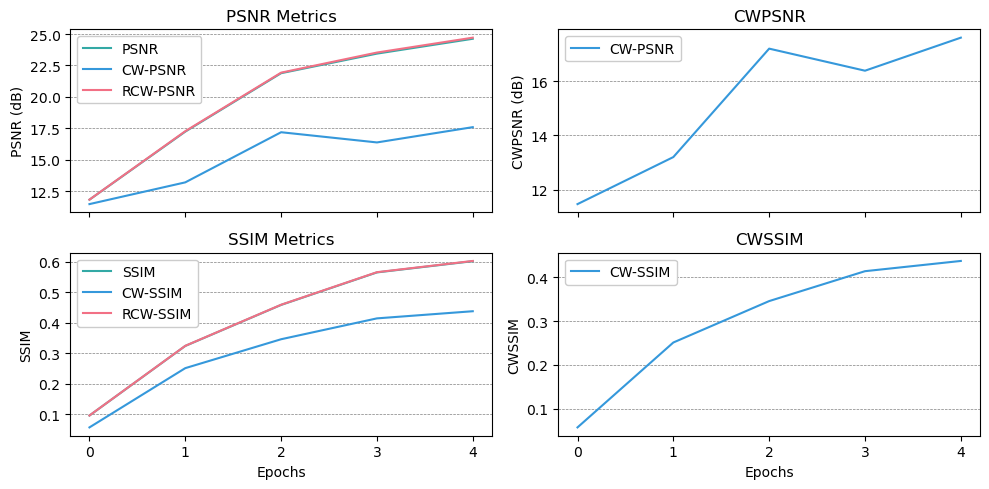

In [20]:
plot_metrics(validation_results, save_path=f"results/RUN_{file_name}.png")


In [21]:
transform = transforms.Compose([S2S1Normalize(),myToTensor()])
test_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_test,
                            s2_t1_dir=s2_t1_dir_test,
                            s1_t2_dir=s1_t2_dir_test,
                            s2_t2_dir=s2_t2_dir_test,
                            transform=transform,
                            two_way=TWO_WAY_DATASET,
                            binary_s1cm=False
                            )
test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
    )

In [22]:
# save_some_examples(gen_model, test_dataset, NUM_EPOCHS, folder="evaluation",cm_input=INPUT_CHANGE_MAP, img_indx=2)

In [23]:
whole_test_eval_results_all = eval_fn(gen_model, test_loader, wssim, wpsnr, hard_test = True, in_change_map=INPUT_CHANGE_MAP)
whole_test_eval_results_first_half = eval_fn(gen_model, test_loader, wssim, wpsnr, hard_test = True,loader_part='first', in_change_map=INPUT_CHANGE_MAP)
whole_test_eval_results_second_half = eval_fn(gen_model, test_loader, wssim, wpsnr, hard_test = True,loader_part='second', in_change_map=INPUT_CHANGE_MAP)
pprint.pprint(whole_test_eval_results_all)
pprint.pprint(whole_test_eval_results_first_half)
pprint.pprint(whole_test_eval_results_second_half)

100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

{'PSNR': {'cwpsnr_mean': 22.53553444351686,
          'psnr_mean': 24.622453689575195,
          'rcwpsnr_mean': 24.77430103470716},
 'SSIM': {'cwssim_mean': 0.5842723901692054,
          'rcwssim_mean': 0.6027980414994952,
          'ssim_mean': 0.6010051965713501}}
{'PSNR': {'cwpsnr_mean': 22.289294240664837,
          'psnr_mean': 24.247339248657227,
          'rcwpsnr_mean': 24.392942687454056},
 'SSIM': {'cwssim_mean': 0.5759174657517704,
          'rcwssim_mean': 0.5925589997704491,
          'ssim_mean': 0.5910366177558899}}
{'PSNR': {'cwpsnr_mean': 22.398356945488217,
          'psnr_mean': 24.340967178344727,
          'rcwpsnr_mean': 24.53158172168119},
 'SSIM': {'cwssim_mean': 0.5856259832578437,
          'rcwssim_mean': 0.6059921229193465,
          'ssim_mean': 0.6032975912094116}}


In [24]:
hard_eval_results_all = eval_fn(gen_model, hard_test_loader, wssim, wpsnr, hard_test = True, loader_part="all", in_change_map=INPUT_CHANGE_MAP)
hard_eval_results_first_half = eval_fn(gen_model, hard_test_loader, wssim, wpsnr, hard_test = True, loader_part="first", in_change_map=INPUT_CHANGE_MAP)
hard_eval_results_second_half = eval_fn(gen_model, hard_test_loader, wssim, wpsnr, hard_test = True, loader_part="second", in_change_map=INPUT_CHANGE_MAP)
pprint.pprint(hard_eval_results_all)
pprint.pprint(hard_eval_results_first_half)
pprint.pprint(hard_eval_results_second_half)

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

{'PSNR': {'cwpsnr_mean': 17.594134493608315,
          'psnr_mean': 24.622453689575195,
          'rcwpsnr_mean': 24.710785833837285},
 'SSIM': {'cwssim_mean': 0.43729087347022816,
          'rcwssim_mean': 0.6018083384008645,
          'ssim_mean': 0.6010052561759949}}
{'PSNR': {'cwpsnr_mean': 17.6564610909405,
          'psnr_mean': 24.247339248657227,
          'rcwpsnr_mean': 24.332281833590557},
 'SSIM': {'cwssim_mean': 0.4452485239890499,
          'rcwssim_mean': 0.591810575879479,
          'ssim_mean': 0.5910366177558899}}
{'PSNR': {'cwpsnr_mean': 17.668992536298692,
          'psnr_mean': 24.340967178344727,
          'rcwpsnr_mean': 24.418690436795742},
 'SSIM': {'cwssim_mean': 0.39214275248589053,
          'rcwssim_mean': 0.6043012560127144,
          'ssim_mean': 0.6032975912094116}}


In [25]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)
print("File Name:", file_name)

Current Date and Time: 2023-05-20 12:34:13
File Name: D_2023_05_20_T_12_32


In [26]:
log_json = {}
log_json["Time"] = {"Start": start_string, "Finish": finish_string}
log_json["IN_KAGGLE"] = IN_KAGGLE
log_json["TWO_WAY_DATASET"] = TWO_WAY_DATASET
log_json["INPUT_CHANGE_MAP"] = INPUT_CHANGE_MAP
log_json["S2_INCHANNELS"] = S2_INCHANNELS
log_json["S1_INCHANNELS"] = S1_INCHANNELS
log_json["LEARNING_RATE"] = LEARNING_RATE
log_json["BATCH_SIZE"] = BATCH_SIZE
log_json["NUM_WORKERS"] = NUM_WORKERS
log_json["IMAGE_SIZE"] = IMAGE_SIZE
log_json["WEIGHTED_LOSS"] = WEIGHTED_LOSS
log_json["L1_LAMBDA"] = L1_LAMBDA
log_json["CHANGED_L1_WEIGHT"] = CHANGED_L1_WEIGHT
log_json["NUM_EPOCHS"] = NUM_EPOCHS
log_json["LOAD_MODEL"] = LOAD_MODEL
log_json["SAVE_MODEL"] = SAVE_MODEL
log_json["SAVE_MODEL_EVERY_EPOCH"] = SAVE_MODEL_EVERY_EPOCH
log_json["SAVE_EXAMPLE_PLOTS"] = SAVE_EXAMPLE_PLOTS
log_json["EXAMPLES_TO_PLOT"] = EXAMPLES_TO_PLOT
log_json["CHECKPOINT_DISC"] = CHECKPOINT_DISC
log_json["CHECKPOINT_GEN"] = CHECKPOINT_GEN
log_json["RANDOM_SEED"] = RANDOM_SEED
log_json["HardEval"] = {"Hard All": hard_eval_results_all,
                        "Hard First Half": hard_eval_results_first_half,
                        "Hard Second Half": hard_eval_results_second_half}

log_json["FullEval"] = {"Full Test Dataset": whole_test_eval_results_all,
                        "First Half Test Dataset": whole_test_eval_results_first_half,
                        "Second Half Test Dataset": whole_test_eval_results_second_half}

psnr_list, cw_psnr_list, rcwpsnr_list, ssim_list, cwssim_list, rcwssim_list = separate_lists(validation_results)
log_json["Validation Lists"] = {"PSNR": psnr_list, "CWPSNR": cw_psnr_list, "RCWPSNR": rcwpsnr_list, "SSIM": ssim_list, "CWSSIM": cwssim_list, "RCWSSIM": rcwssim_list}

with open(f"results/RUN_{file_name}.json", "w") as fp:
    json.dump(log_json, fp, indent=4)

In [27]:
# Redeclare the test dataset with binary_s1cm = False for plotting
transform = transforms.Compose([S2S1Normalize(),myToTensor()])
test_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_test,
                            s2_t1_dir=s2_t1_dir_test,
                            s1_t2_dir=s1_t2_dir_test,
                            s2_t2_dir=s2_t2_dir_test,
                            transform=transform,
                            two_way=TWO_WAY_DATASET,
                            binary_s1cm=False
                            )


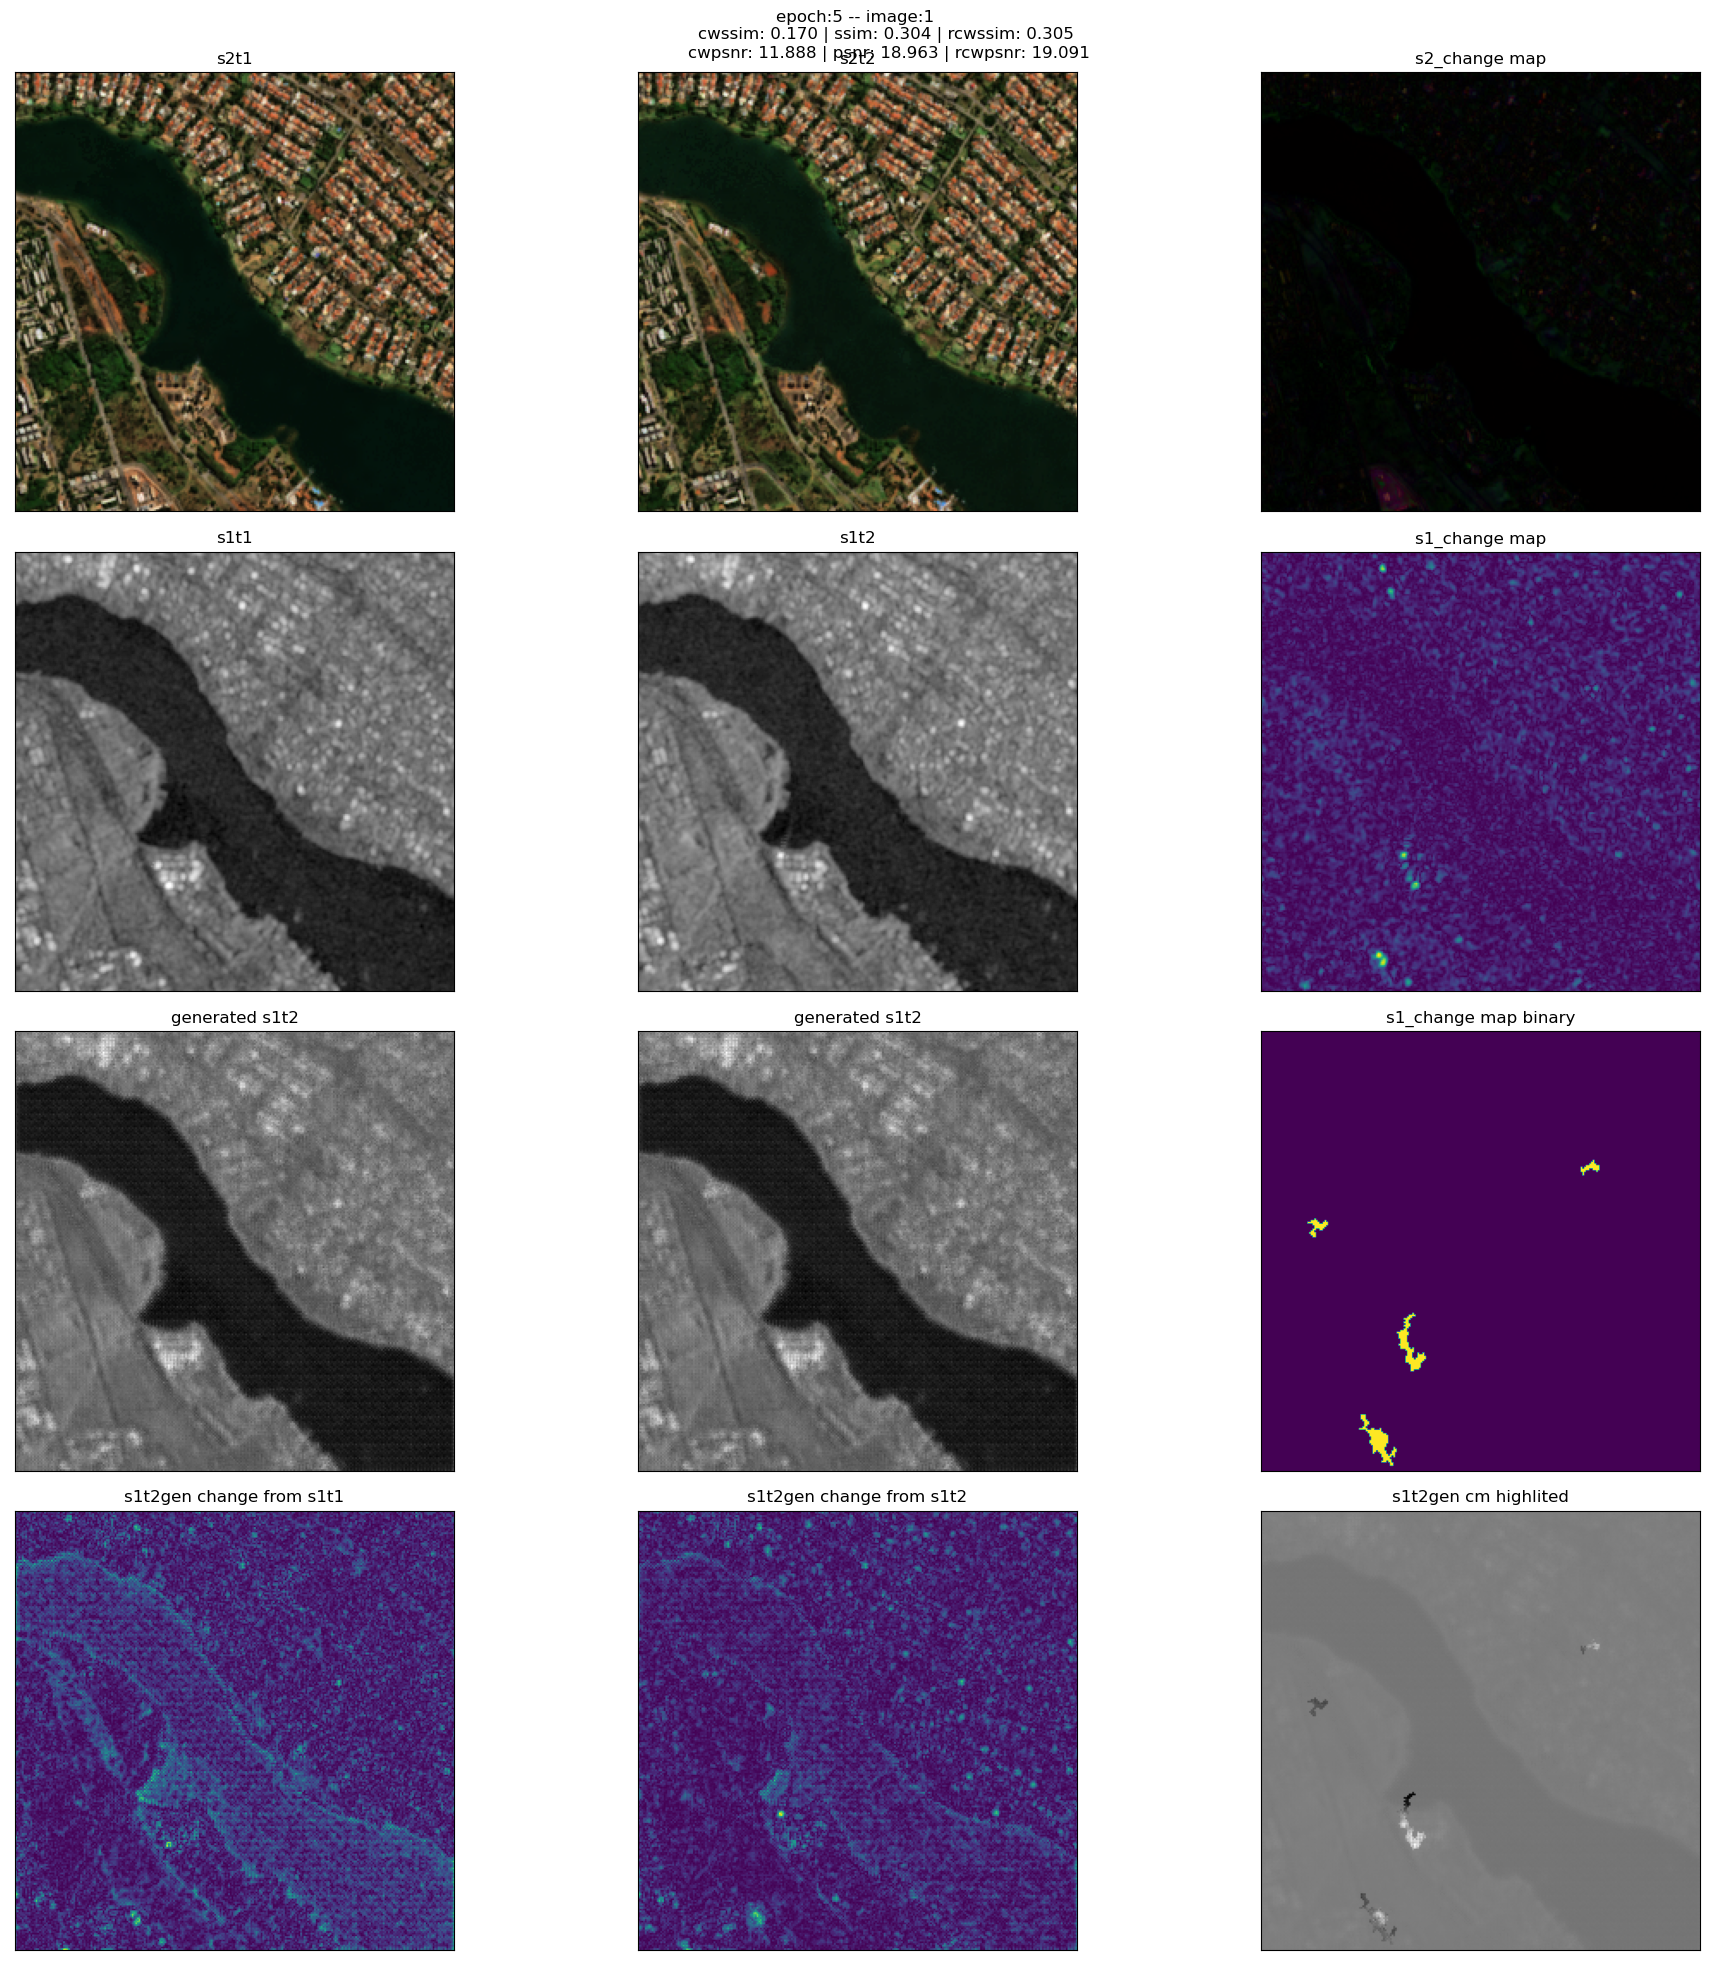

In [28]:
save_some_examples(gen_model, test_dataset, NUM_EPOCHS,
                   folder="test_evaluation_plots_1",cm_input=INPUT_CHANGE_MAP,
                   img_indx=1, just_show = True, fig_size=(20,20))

In [29]:
import torch.nn.functional as F


torch.Size([1, 1, 16, 16]) torch.Size([1, 1, 16, 16])


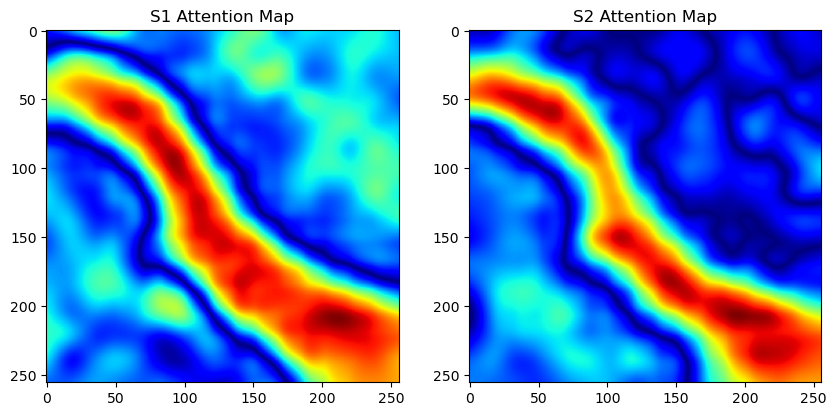

In [39]:
print()
try:
    gen_model.eval()
    print(gen_model.glam4_s1.local_spatial_att.local_att_map.shape, gen_model.glam4_s2.local_spatial_att.local_att_map.shape)
    # Ploting both attention maps in a subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    map = gen_model.glam4_s1.local_spatial_att.local_att_map
    map = F.interpolate(map, size=(256, 256), mode='bicubic', align_corners=True)
    map = np.abs(map[0, 0, :, :].detach().cpu().numpy())
    axs[0].imshow(map, cmap='jet')
    axs[0].set_title('S1 Attention Map')
    map = gen_model.glam4_s2.local_spatial_att.local_att_map
    map = F.interpolate(map, size=(256, 256), mode='bicubic', align_corners=True)
    map = np.abs(map[0, 0, :, :].detach().cpu().numpy())
    axs[1].imshow(map, cmap='jet')
    axs[1].set_title('S2 Attention Map')
    #plt.savefig(f"results/RUN_{file_name}_attention_maps.png")
    plt.show()
    gen_model.train()
except:
    print("No v1.6 attention maps to plot")



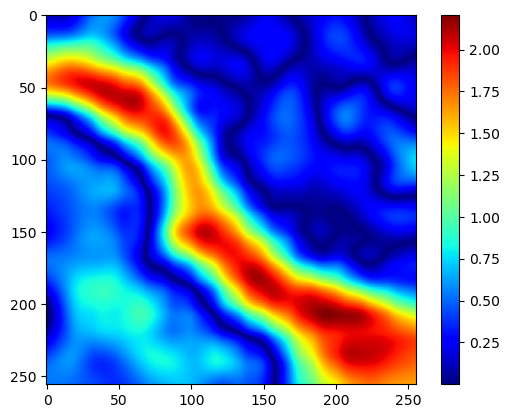

In [82]:
plt.imshow(map, cmap='jet')
plt.colorbar()
plt.show()

In [45]:
import cv2
import numpy as np


In [54]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())
def convert2uint8(x):
    return (x * 255).astype(np.uint8)

(256, 256) 0 255
(256, 256, 3)
(256, 256, 3) (256, 256, 1) (256, 256, 1)
result shape (256, 256, 3)


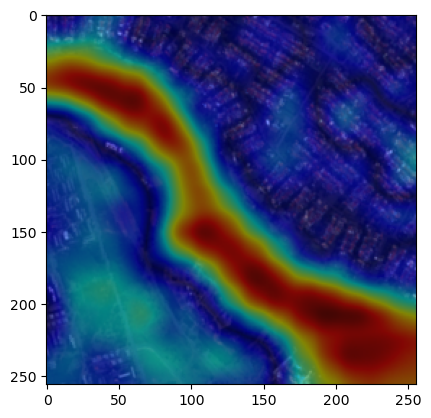

In [87]:
def save_some_examples(gen, val_dataset ,epoch, folder, cm_input, img_indx = 1, just_show = False, fig_size = (8,12)):
    s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm  = val_dataset[img_indx]
    s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm = s2t2.to(DEVICE),s1t2.to(DEVICE),s2t1.to(DEVICE),s1t1.to(DEVICE),cm.to(DEVICE),rcm.to(DEVICE),s1cm.to(DEVICE)
    if cm_input:
        s2t2 = torch.cat((s2t2, cm), dim=0)
        s1t1 = torch.cat((s1t1, rcm), dim=0)
    
    if os.path.exists(folder) == False:
        os.mkdir(f"{folder}/")
    wssim = WSSIM(data_range=1.0)  
    gen.eval()
    with torch.no_grad():
        s1t2_generated = gen(s2t2.unsqueeze(0).to(torch.float32), s1t1.unsqueeze(0).to(torch.float32))
        s1t2_generated = s1t2_generated.squeeze(0)
        try:
            s1_att_map = gen.glam4_s1.local_spatial_att.local_att_map
            s1_att_map = F.interpolate(s1_att_map, size=(256, 256), mode='bicubic', align_corners=True)
            s1_att_map = np.abs(s1_att_map[0, 0, :, :].detach().cpu().numpy())
            s1_att_map = convert2uint8(normalize(s1_att_map))
            s2_att_map = gen.glam4_s2.local_spatial_att.local_att_map
            s2_att_map = F.interpolate(s2_att_map, size=(256, 256), mode='bicubic', align_corners=True)
            s2_att_map = np.abs(s2_att_map[0, 0, :, :].detach().cpu().numpy())
            s2_att_map = convert2uint8(normalize(s2_att_map))
        except:
            raise Exception("No attention maps to plot")
        print(s1_att_map.shape, np.min(s1_att_map), np.max(s1_att_map))

        s1_colormap = cv2.applyColorMap(s1_att_map, cv2.COLORMAP_JET)
        s2_colormap = cv2.applyColorMap(s2_att_map, cv2.COLORMAP_JET)
        # Color maps are in BGR format. But matplotlib uses RGB format.
        s1_colormap = cv2.cvtColor(s1_colormap, cv2.COLOR_BGR2RGB)
        s2_colormap = cv2.cvtColor(s2_colormap, cv2.COLOR_BGR2RGB)
        

        print(s2_colormap.shape)
        
        s1t2_np = s1t2.permute(1,2,0).cpu().numpy()
        s1t2_np = convert2uint8(normalize(s1t2_np))
        s1t2_generated_np = s1t2_generated.permute(1,2,0).cpu().numpy()
        s1t2_generated_np = convert2uint8(normalize(s1t2_generated_np))
        s2t2_np = s2t2.permute(1,2,0)[:,:,[2,1,0]].cpu().numpy()
        s2t2_np = convert2uint8(normalize(s2t2_np))
        
        
        print(s2t2_np.shape, s1t2_np.shape, s1t2_generated_np.shape)
        # # Stack RGB image and colormap
        # s2_stacked = np.stack((rgb_image, colormap), axis=-1)

        
        # Overlay attention map on RGB image
        alpha = 0.5
        result = cv2.addWeighted(s2t2_np, 1 - alpha, s2_colormap, alpha, 0)

        print(f"result shape {result.shape}")
        
        plt.imshow(result)
        plt.show()


save_some_examples(gen_model, test_dataset, 1, "results", cm_input = INPUT_CHANGE_MAP, img_indx = 1, just_show = True, fig_size = (8,12))

In [ ]:
try:
    gen_model.eval()
    print(gen_model.bam_init_s1.spatial_att.att_map.shape, gen_model.bam_init_s2.spatial_att.att_map.shape)
    # Ploting both attention maps in a subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    map = gen_model.bam_init_s1.spatial_att.att_map

    map = np.abs(map[0, 0, :, :].detach().cpu().numpy())
    axs[0].imshow(map, cmap='jet')
    axs[0].set_title('S1 Attention Map')
    map = gen_model.bam_init_s2.spatial_att.att_map

    map = np.abs(map[0, 0, :, :].detach().cpu().numpy())
    axs[1].imshow(map, cmap='jet')
    axs[1].set_title('S2 Attention Map')
    #plt.savefig(f"results/RUN_{file_name}_attention_maps.png")
    plt.show()
    gen_model.train()
except:
    print("No v1.7 attention maps to plot")


No v1.7 attention maps to plot


In [32]:
# import shutil
# shutil.rmtree("test_evaluation_plots")

In [33]:
# for img_i in range(1,len(test_dataset)//2, 2):
#     save_some_examples(gen_model, test_dataset, NUM_EPOCHS, folder="test_evaluation_plots_1",cm_input=INPUT_CHANGE_MAP, img_indx=img_i)
# !zip -r /kaggle/working/test_evalplot1.zip  /kaggle/working/test_evaluation_plots_1/

In [34]:
# for img_i in range((len(test_dataset)//2)+1,len(test_dataset), 2):
#     save_some_examples(gen_model, test_dataset, NUM_EPOCHS, folder="test_evaluation_plots_2",cm_input=INPUT_CHANGE_MAP, img_indx=img_i)
# !zip -r /kaggle/working/test_evalplot2.zip  /kaggle/working/test_evaluation_plots_2/